<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part6/P6_Ch03_CH01_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 목적 지향 대화시스템
## 01. 목적 지향 대화 시스템  
1) 자연어 이해(NLU) 실습  

1_임베딩  
2_의도 분류  
3_정보 추출  
4_OOD 분류  
5_NLU 시스템 구성

2) 대화 관리 및 자연어 생성  

(DM) 실습  

1_NLG  
2_DM 시스템 구성

## Word2Vec으로 embedding
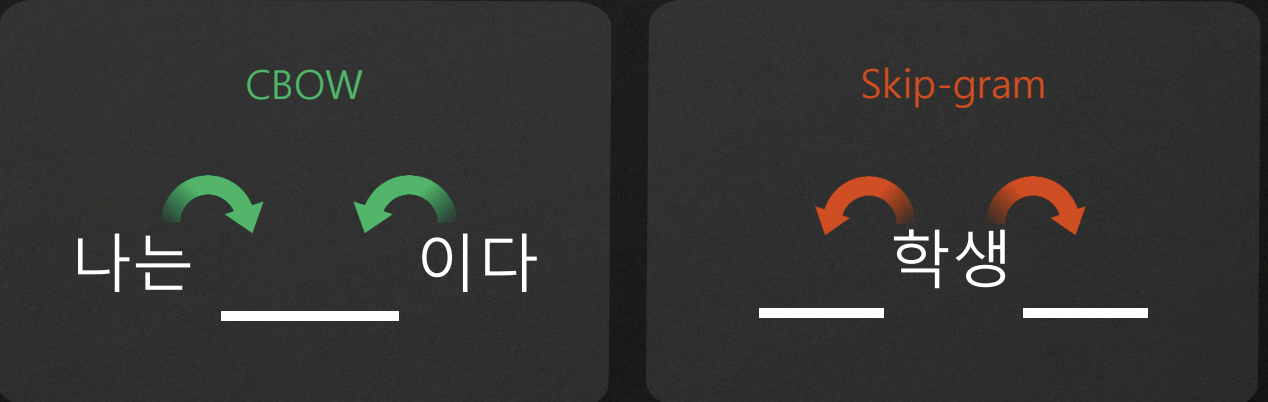

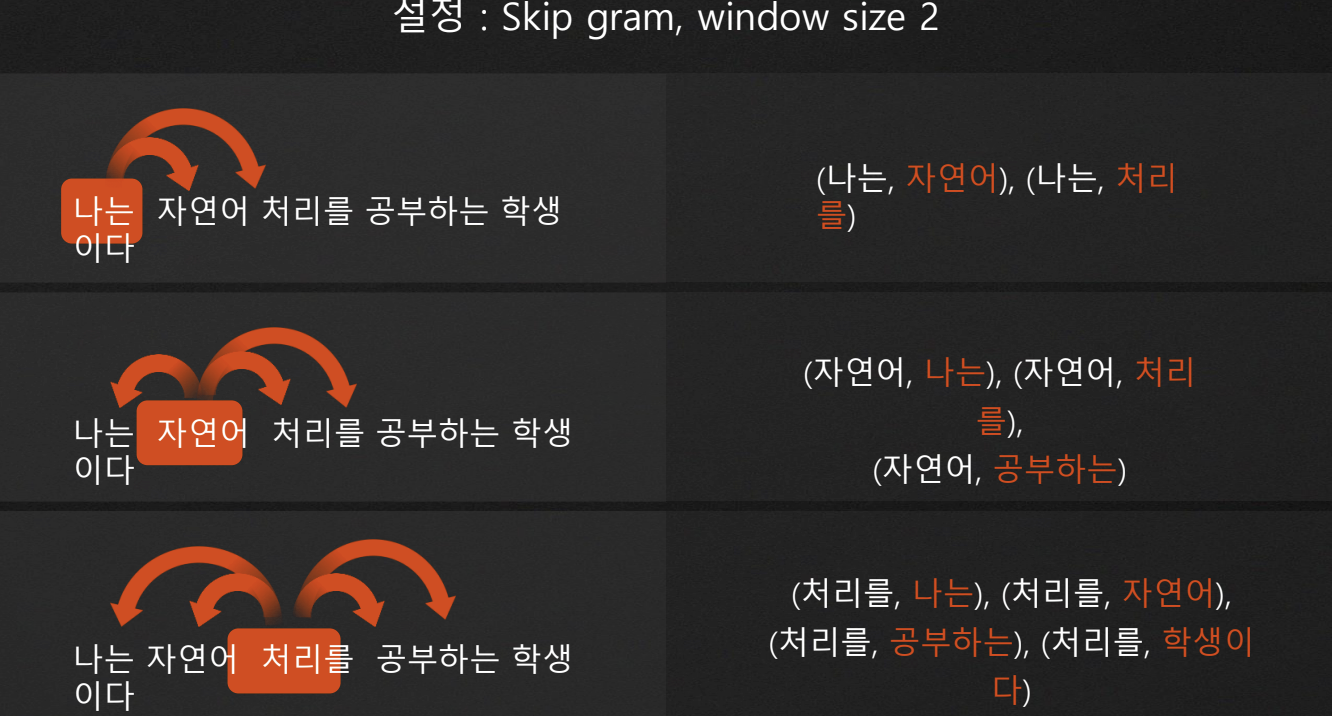

In [6]:
!pip uninstall gensim
!pip install gensim==3.4.0

  Using cached gensim-3.4.0-cp310-cp310-linux_x86_64.whl


In [7]:
import os
import sys
import json
import torch
import pandas as pd
import numpy as np

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec



In [8]:
class Preprocessing:
    '''
    데이터의 최대 token길이가 10이지만
    실제 환경에서는 얼마의 길이가 들어올지 몰라 적당한 길이 부여
    '''

    def __init__(self, max_len = 20):
        self.max_len = max_len
        self.PAD = 0

    def pad_idx_sequencing(self, q_vec):
        q_len = len(q_vec)
        diff_len = q_len - self.max_len
        if(diff_len>0):
            q_vec = q_vec[:self.max_len]
            q_len = self.max_len
        else:
            pad_vac = [0] * abs(diff_len)
            q_vec += pad_vac

        return q_vec

class MakeDataset:
    def __init__(self):

        self.intent_data_dir = "/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇/data/dataset/intent_data.csv"
        self.prep = Preprocessing()

    def tokenize(self, sentence):
        ''' 띄어쓰기 단위로 tokenize 적용'''
        return sentence.split()

    def tokenize_dataset(self, dataset):
        ''' Dataset에 tokenize 적용'''
        token_dataset = []
        for data in dataset:
            token_dataset.append(self.tokenize(data))
        return token_dataset

    def make_embed_dataset(self, ood = False):
        embed_dataset = pd.read_csv(self.intent_data_dir)
        embed_dataset = embed_dataset["question"].to_list()
        embed_dataset = self.tokenize_dataset(embed_dataset)

        return embed_dataset

In [9]:
dataset = MakeDataset()
embeded_dataset = dataset.make_embed_dataset()

In [12]:
embeded_dataset

[['야', '먼지', '알려주겠니'],
 ['아니', '먼지', '정보', '알려주세요'],
 ['그', '때', '미세먼지', '어떨까'],
 ['그', '때', '먼지', '좋으려나'],
 ['미세먼지', '어떨', '것', '같은데'],
 ['그러면', '미세먼지', '어때'],
 ['미세먼지', '말해줄래'],
 ['먼지', '미세먼지'],
 ['참', '먼지', '많이', '꼈나'],
 ['참', '먼지', '어떠냐'],
 ['야', '미세먼지', '어때'],
 ['토요일', '먼지', '알려줘'],
 ['헐', '먼지', '어떠려나'],
 ['전주', '미세먼지', '어떤지', '말해줘'],
 ['미세먼지', '궁금해서', '물어봤어'],
 ['아', '그러면', '먼지', '알려주세요'],
 ['아', '맞다', '먼지', '어떠려나'],
 ['저기', '현재', '먼지', '어떠려나'],
 ['토요일', '먼지', '알려주겠니'],
 ['먼지', '궁금해'],
 ['지금', '먼지', '어떤데'],
 ['저기', '미세먼지', '어떨까'],
 ['먼지', '완전', '문젠데'],
 ['세종', '먼지', '한', '번', '알려줘'],
 ['모레', '먼지', '궁금해'],
 ['먼지', '궁금해요'],
 ['미세먼지', '어떨까'],
 ['지금', '미세먼지', '어떨까', '심해지네'],
 ['현재', '미세먼지', '어떨까'],
 ['공기', '미세먼지', '좀', '알려줄래'],
 ['미세먼지', '먼지'],
 ['미세먼지', '좀', '먼지'],
 ['월요일', '근데', '먼지', '어떠려나'],
 ['미세먼지', '없니', '현재'],
 ['지금', '미세먼지', '없니', '현재'],
 ['공기', '미세먼지', '현재'],
 ['공기상태', '알려줘'],
 ['아', '먼지', '심하네'],
 ['어떤데', '먼지'],
 ['먼지', '알려줬으면', '졸겠어'],
 ['미세먼지', '없나', '하'],
 ['지금', '먼지', 

In [13]:
 class EpochLogger(CallbackAny2Vec):
    '''Callback to log information about training'''
    '''https://radimrehurek.com/gensim/models/callbacks.html'''
    '''학습 중간에 프린트를 하기 위한 logger'''
    def __init__(self):
        self.epoch = 0

    def on_epoch_begin(self, model):
        print("Epoch #{} start".format(self.epoch))

    def on_epoch_end(self, model):
        print("Epoch #{} end".format(self.epoch))
        self.epoch += 1

class MakeEmbed:
    '''https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec'''
    '''https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#online-training-resuming-training'''
    def __init__(self):
        self.model_dir = "./"
        self.vector_size = 300 # 임베딩 사이즈
        self.window_size = 3   # 몇개의 단어로 예측을 할것인지
        self.workers = 8       # 학습 스레드의 수
        self.min_count = 2     # 단어의 최소 빈도수 (해당 수 미만은 버려진다)
        self.iter = 1000       # 1epoch당 학습 수
        self.sg = 1            # 1: skip-gram, 0: CBOW
        self.model_file = "/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇/data/pretraining/word2vec_skipgram_{}_{}_{}".format(self.vector_size, self.window_size, self.min_count)
        self.epoch_logger = EpochLogger()

    def word2vec_init(self): # word2vec 초기화 및 세팅
        self.word2vec = Word2Vec(size=self.vector_size,
                         window=self.window_size,
                         workers=self.workers,
                         min_count=self.min_count,
                         compute_loss=True,
                         iter=self.iter)

    def word2vec_build_vocab(self, dataset): # 단어장 만들기
        self.word2vec.build_vocab(dataset)

    def word2vec_most_similar(self, query): # 비슷한 단어 계산
        print(self.word2vec.most_similar(query))

    def word2vec_train(self,embed_dataset, epoch = 0): # 학습
        if(epoch == 0):
            epoch = self.word2vec.epochs + 1
        self.word2vec.train(
            sentences=embed_dataset,
            total_examples=self.word2vec.corpus_count,
            epochs=epoch,
            callbacks=[self.epoch_logger]
        )

        self.word2vec.save(self.model_file + '.gensim')
        self.vocab = self.word2vec.wv.index2word
        self.vocab = {word: i for i, word in enumerate(self.vocab)}

    def load_word2vec(self):

        if not os.path.exists(self.model_file+'.gensim'):
            raise Exception("모델 로딩 실패 "+ self.model_file+'.gensim')


        self.word2vec = Word2Vec.load(self.model_file+'.gensim')
        self.vocab = self.word2vec.wv.index2word
        self.vocab.insert(0,"<UNK>") # vocab애 없는 토큰등장할 경우를 대비한 <UNK> 토큰을 vocab에 삽입, index 1
        self.vocab.insert(0,"<PAD>") # 길이를 맞추기 위한 padding을 위해 <PAD> 토큰을 vacab에 삽입, index 0
        self.vocab = {word: i for i, word in enumerate(self.vocab)}

    def query2idx(self, query):
        sent_idx = []

        for word in query:
            if(self.vocab.get(word)):
                idx = self.vocab[word]
            else:
                idx = 1

            sent_idx.append(idx)

        return sent_idx

In [14]:
embed = MakeEmbed()
embed.word2vec_init()
embed.word2vec.build_vocab(embeded_dataset)

In [15]:
embed.word2vec.wv.most_similar('미세먼지')

[('봉화', 0.18443861603736877),
 ('말해주세요', 0.17970919609069824),
 ('수산시장', 0.17930012941360474),
 ('맑니', 0.16030532121658325),
 ('1월', 0.15013420581817627),
 ('들러봐야', 0.1497955024242401),
 ('시원해', 0.14900019764900208),
 ('샌드위치', 0.14689019322395325),
 ('단양군', 0.14378204941749573),
 ('부려나', 0.1428675651550293)]

In [17]:
embed.word2vec_train(embeded_dataset, 10)

Epoch #0 start
Epoch #0 end
Epoch #1 start
Epoch #1 end
Epoch #2 start
Epoch #2 end
Epoch #3 start
Epoch #3 end
Epoch #4 start
Epoch #4 end
Epoch #5 start
Epoch #5 end
Epoch #6 start
Epoch #6 end
Epoch #7 start
Epoch #7 end
Epoch #8 start
Epoch #8 end
Epoch #9 start
Epoch #9 end


In [18]:
embed.word2vec.wv.most_similar('미세먼지')

[('먼지', 0.9100340604782104),
 ('오늘', 0.8490082025527954),
 ('날씨', 0.8442705273628235),
 ('내일모레', 0.8273838758468628),
 ('모레', 0.8171143531799316),
 ('것', 0.7851151823997498),
 ('수요일', 0.7796220183372498),
 ('충남', 0.7784090638160706),
 ('그니까', 0.7774313688278198),
 ('아니', 0.777021050453186)]

## word2index

In [20]:
sentence =embeded_dataset[0]

In [21]:
sentence

['야', '먼지', '알려주겠니']

In [22]:
embed.query2idx(sentence)

[369, 35, 425]

In [23]:
w2i = embed.query2idx(sentence)

In [24]:
dataset.prep.pad_idx_sequencing(w2i)

[369, 35, 425, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## word2vec load

In [26]:
list(embed.vocab)[:5]

['미세먼지', '추천해', '날씨', '어디', '알려줘']

In [27]:
embed.load_word2vec()

In [28]:
len(embed.vocab)

1481

In [29]:
embed.vocab

{'<PAD>': 0,
 '<UNK>': 1,
 '미세먼지': 2,
 '추천해': 3,
 '날씨': 4,
 '어디': 5,
 '알려줘': 6,
 '알려줄래': 7,
 '서울': 8,
 '주변': 9,
 '하는': 10,
 '근처': 11,
 '알려주세요': 12,
 '있니': 13,
 '맛집': 14,
 '우산': 15,
 '알려주라': 16,
 '알고싶어': 17,
 '한': 18,
 '마스크': 19,
 '있냐': 20,
 '공기': 21,
 '줘': 22,
 '여행지': 23,
 '주세요': 24,
 '주라': 25,
 '좋은': 26,
 '휴양지': 27,
 '추천': 28,
 '관광지': 29,
 '주': 30,
 '집': 31,
 '명소': 32,
 '이번': 33,
 '내일': 34,
 '눈': 35,
 '오늘': 36,
 '먼지': 37,
 '할만': 38,
 '식당': 39,
 '비': 40,
 '말해': 41,
 '그럼': 42,
 '수': 43,
 '그러면': 44,
 '할까': 45,
 '유명한': 46,
 '제일': 47,
 '맛있게': 48,
 '사진': 49,
 '있는': 50,
 '어때': 51,
 '인기': 52,
 '셀카': 53,
 '관광': 54,
 '모레': 55,
 '어떨까': 56,
 '어떤지': 57,
 '가는데': 58,
 '꼭': 59,
 '강원도': 60,
 '챙길까': 61,
 '오는지': 62,
 '구경': 63,
 '들려야': 64,
 '써야': 65,
 '가봐야': 66,
 '부산': 67,
 '말해줘': 68,
 '오존': 69,
 '해주라': 70,
 '전라북도': 71,
 '충청남도': 72,
 'ㅋㅋ': 73,
 '괜찮은': 74,
 '전라남도': 75,
 '광주': 76,
 '만': 77,
 '가까운': 78,
 '충청도': 79,
 '오니': 80,
 '올까': 81,
 '해주세요': 82,
 '경기도': 83,
 '제주도': 84,
 '챙겨야': 85,
 '혹시': 86,
 '전주': 87,
